# Import Modules

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import typing as tp
import time
import random
import math
from collections import deque
from dataclasses import dataclass

import torch
from torch import nn, Tensor

SEED = 42 # SEED MATTERS A LOT!!! Change it and it might not work anymore
random.seed(SEED)
np.random.seed(SEED+1)
torch.manual_seed(SEED+2)
torch.use_deterministic_algorithms(mode=True, warn_only=False)

# Pong Environment

## Actions
* ![image.png](images/pong_action.png)

    ```python
    0: NOOP       => Nothing
    1: Fire       => Nothing # dont know the difference between NOOP and Fire
    2: Right      => Up
    3: Left       => Down
    4: RightFire  => Up      # dont know the difference between Right and RightFire
    5: LeftFire   => Down    # dont know the difference between Left and LeftFire
    ```
* We are going to keep only `Fire (1)`, `RIGHT (2)`, `LEFT (3)`
* info contains: `{'lives': ?, 'episode_frame_number': ?, 'frame_number': ?}`

## Rewards
* You get score points for getting the ball to pass the opponent’s paddle. You lose points if the ball passes your paddle. For a more detailed documentation, see the AtariAge page.
* Every time you leave the ball you get a `-1` reward and when the opponent (hard-coded algo) leaves the ball you get `+1` reward

* `done` after 20/21 points in one episode/game \
  ![pong](images/pong_game_img.png)

In [ ]:
env = gym.make("ALE/Pong-v5", difficulty=0, obs_type="rgb")
state, info = env.reset()
state.shape, info

# Ops

In [3]:
def plot_environment(env:gym.Env, figsize:tuple[int, int]=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames:list, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animation = anim.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    return animation

def show_one_episode(action_sampler:tp.Callable, n_max_steps=500, repeat=False):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset()
    with torch.no_grad():
        for step in range(n_max_steps):
            frames.append(env.render())
            action = action_sampler(obs)
            obs, reward, done, truncated, info = env.step(action)
            if done or truncated:
                print("done at step", step+1)
                break
    env.close()
    return plot_animation(frames, repeat=repeat)

In [4]:
class CosineDecayWithWarmup:
    def __init__(
        self,
        warmup_steps:int,
        max_learning_rate:float,
        decay_steps:int,
        min_learning_rate:float
    ):
        self.warmup_steps = warmup_steps
        self.max_learning_rate = max_learning_rate
        self.decay_steps = decay_steps
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        # linear warmup for warmup_steps steps
        if step < self.warmup_steps:
            return self.max_learning_rate * step / self.warmup_steps
        # if it > decay_steps, return min learning rate
        if step > self.decay_steps:
            return self.min_learning_rate
        # in between, use cosine decay down to min learning rate
        decay_ratio = (step - self.warmup_steps) / (self.decay_steps - self.warmup_steps)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return self.min_learning_rate + coeff * (self.max_learning_rate - self.min_learning_rate)

# Expected Sarsa

<!-- ## Preprocessing
*  `________BEFORE_FRAME______________________CURRENT_FRAME____________________________ MODEL_INPUT = CURRENT_FRAME - BEFORE_FRAME`\
  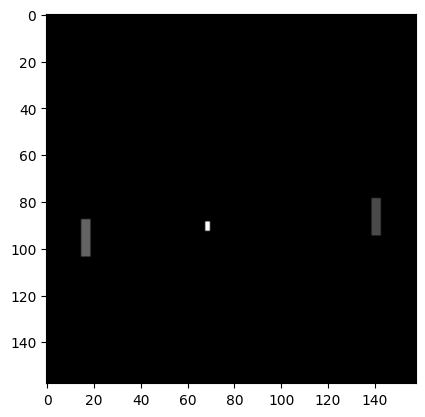 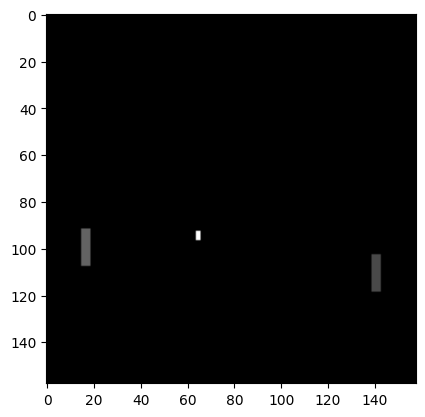 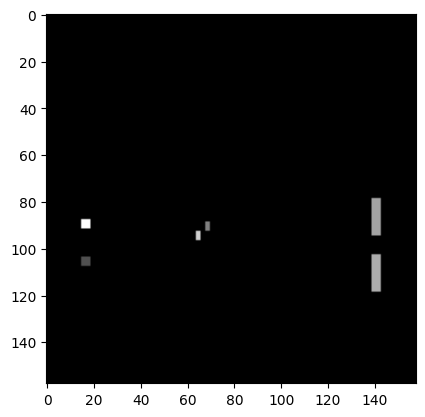 -->

In [5]:
def prepro(I:np.ndarray|Tensor):
    """https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5"""
    assert len(I.shape) == 4, "must be (B, H, W, C)"
    I = I.copy().astype(np.float32) if isinstance(I, np.ndarray) else I.clone().float()
    I = I[:, 35:195] # (B, 160, 160, 3)
    I = I[:, ::2,::2, 0] # (B, 80, 80)
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I[:, None]/255.0 # (B, 1, 80, 80)

In [ ]:
@dataclass
class config:
    num_iters:int = 600
    num_episodes_per_iter:int = 10
    max_steps_per_episode:int = 1000 # will not go beyond 500, simply...
    
    gamma:float = 0.99 # changed from 0.95, improved performance...
    
    lr:float = 0.01
    weight_decay:float = 0.0
    batch_size:int = 32 # 64
    constlr_steps:int = int(num_iters*0.4375)

    device:torch.device = torch.device("cuda" if False else "cpu") # cpu good for very very small models
    dtype:torch.dtype = torch.float32 if "cpu" in device.type else torch.bfloat16

    autocast:torch.autocast = torch.autocast(
        device_type=device.type, dtype=dtype, enabled="cuda" in device.type
    )
    logging_interval:int = 1

    generator:torch.Generator = torch.Generator(device=device).manual_seed(SEED+343434)

print(config())

In [7]:
class DQN(nn.Module): # Karpathy's model (policy gradient): 1.2802 Million parameters 
    def __init__(self, in_channels:int, num_actions:int):
        super().__init__()
        self.in_channels = in_channels
        self.num_actions = num_actions
        self.model = nn.ModuleList([                                                         # (B, 3 or 1, 80, 80)
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4),    # (B, 32, 19, 19)
            nn.ReLU(),                                                                       # (B, 32, 19, 19)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),             # (B, 64, 8, 8)
            nn.ReLU(),                                                                       # (B, 64, 8, 8)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),            # (B, 128, 3, 3)
            nn.ReLU(),                                                                       # (B, 128, 3, 3)                             
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),           # (B, 256, 1, 1)
            nn.ReLU(),                                                                       # (B, 256, 1, 1)
            nn.Flatten(),                                                                    # (B, 256)
            nn.Linear(in_features=256, out_features=128),                                    # (B, 128)
            nn.Linear(in_features=128, out_features=num_actions),                            # (B, num_actions)
        ])

    def forward(self, x:Tensor):
        for layer in self.model:
            x = layer(x)
        return x

In [ ]:
model = DQN(in_channels=1, num_actions=3)
print(model, '\n\nNumber of Parameters: ', sum(p.numel() for p in model.parameters())/1e3, "K\n\nModel out:", model(prepro(torch.randn(2, 210, 160, 3))).shape, '\n\nlen of params:', len(list(model.parameters())))

In [9]:
optimizer = torch.optim.NAdam(
    model.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay,
)

"""def get_lr(step:int):
    if step < config.constlr_steps:
        return config.lr
    return cosine_decay(step)"""

get_lr = CosineDecayWithWarmup(
    warmup_steps=1,
    max_learning_rate=config.lr,
    decay_steps=config.num_iters,
    min_learning_rate=config.lr*0.0
)

In [10]:
# 0 ==> 1: Fire       => Nothing # dont know the difference between NOOP and Fire
# 1 ==> 2: Right      => Up
# 2 ==> 3: Left       => Down

@torch.no_grad()
def action_policy(dqn:DQN, obs:np.ndarray, epsilon:float) -> Tensor:
    if random.random() <= epsilon: return torch.randint(low=0, high=dqn.num_actions, size=(1,), device=config.device, generator=config.generator)
    else: return dqn(torch.as_tensor(obs, device=config.device)).squeeze(0).argmax()
    
def play_step(
    dqn:DQN, 
    current_x:np.ndarray,               # directly from env
    prev_x:tp.Optional[np.ndarray],     # directly from env
    eps:float, 
    replay_buffer:deque
) -> tuple[np.ndarray, float, bool, bool, dict]:
    prev_input:np.ndarray = prepro((current_x - prev_x)[None]) if prev_x is not None else prepro(np.zeros_like(current_x, dtype=np.float32)[None])
    prev_x = current_x.copy()

    action = action_policy(dqn, prev_input, eps).item()
    assert 0 <= action <= 2, f"Action: {action} is not in the range [0, 3)"

    current_x, reward, done, truncated, info = env.step(int(action)+1) # PONG GAME SPECIFIC: adding +1 to action
    next_input:np.ndarray = prepro((current_x - prev_x)[None])
    replay_buffer.append([next_input, action, reward, prev_input, done])
    return current_x, prev_x, reward, done, truncated, info

def sample_instances_from_buffer(replay_buffer:deque, batch_size:int):
    batch_sample = random.sample(replay_buffer, batch_size) # [[s', a, r, s], [s', a, r, s], ...] with len `batch_size`
    return batch_sample

In [11]:
@torch.compile(disable=True)
def train_step(dqn:DQN, replay_buffer:deque):
    # sample instances
    batched_samples = sample_instances_from_buffer(replay_buffer, batch_size=config.batch_size)
    instances = list(zip(*batched_samples))
    next_states, actions, rewards, current_states, dones = [torch.as_tensor(np.array(inst), device=config.device, dtype=torch.float32) for inst in instances]
    current_states, next_states = current_states.squeeze(1), next_states.squeeze(1)
    # input model
    with torch.no_grad():
        with config.autocast:
            next_Q_val:Tensor = dqn(next_states) # (B, num_actions)
            action_probs = next_Q_val.softmax(dim=1) # (B, num_actions)
            expected_Q_val = (next_Q_val*action_probs).sum(dim=1) # (B,)
            #for the condition from the algorithm above
            zero_if_terminal_else_one = (~(dones.bool())).float() # 0 if done else 1
    
        Qtarget:Tensor = (rewards + config.gamma * expected_Q_val * zero_if_terminal_else_one) # (B,)
    
    with config.autocast:
        Qpred:Tensor = dqn(current_states) # (B, num_actions)
        # Select Q values of actions that were taken
        Qpred = Qpred.gather(1, actions.unsqueeze(1).long()).squeeze(-1) # (B,)
        loss = nn.functional.mse_loss(Qpred, Qtarget)
    loss.backward()
    grads = [param.grad for param in dqn.parameters()]; dqn.zero_grad()
    return grads

In [ ]:
def apply_grads(grads:list[list[Tensor]]): # (num_episodes_per_iter=10, 6)
    param_list_len = len(grads[0]) # 6
    to_be_applied_grads:list[list[Tensor]] = [[] for _ in range(param_list_len)] # initialize list

    for n_ep_per_iter, grads_in_ep in enumerate(grads):
        for i, grad in enumerate(grads_in_ep): # (6,)
            to_be_applied_grads[i].append(grad)

    grads:list[Tensor] = [torch.stack(grad_list).mean(dim=0) for grad_list in to_be_applied_grads]
    
    for p, grad in zip(model.parameters(), grads):
        p.grad = grad

    optimizer.step()
    optimizer.zero_grad()

def play():
    replay_buffer = deque(maxlen=config.num_iters*config.num_episodes_per_iter*config.max_steps_per_episode)
    reward_sums_list = []
    # Iter Episodes
    for iter_num in range(1, config.num_iters+1):
        # `else 0.01` works better than `else 0.0`
        epsilon = 0.1 if iter_num<180 else 0.01; t0 = time.time()
        all_grads = []   # (num_episodes_per_iter, 6)
        all_rewards = [] # (num_episodes_per_iter, max_steps_per_episode)

        lr = get_lr(iter_num)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        for episode in range(config.num_episodes_per_iter): # 10
            current_x:np.ndarray = env.reset()[0]; current_rewards = []
            prev_x = None
            while True:
                (
                    current_x, prev_x,
                    reward, done, truncated, info
                ) = play_step(
                    dqn=model, current_x=current_x, prev_x=prev_x, 
                    eps=epsilon, replay_buffer=replay_buffer
                )
                current_rewards.append(reward)
                if done or truncated: break
        
            # train step to get grads
            if len(replay_buffer) > config.batch_size:
                grads = train_step(model, replay_buffer)
                all_grads.append(grads) # (num_episodes_per_iter, 6)

            all_rewards.append(current_rewards)

        # some logging
        reward_sum = sum(list(map(sum, all_rewards))); t1 = time.time(); dt = t1-t0
        reward_sums_list.append(reward_sum)
        if iter_num % config.logging_interval == 0:
            print(f"| Step: {iter_num:<4}/ {config.num_iters:<4} || Average Episode Length {reward_sum:<6.2f} || lr: {lr:<12e} || dt: {dt:<5.2f}s || INFO: {info} ||")

        # average gradients and apply them to increase the stability of the model (idk if this is usually done but it seems like a good idea)
        apply_grads(all_grads)
    return reward_sums_list

episode_lens = play()